In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib
import os
from itertools import groupby
from operator import itemgetter
import sys
sys.path.insert(0, r'..\tools')
from zscore import zscore
from smooth import smooth,ins_smooth
from sort_group import sort_arr2
from raster_plot import raster_plot,raster_plot2

In [2]:
def normalized_time(data,time_window):

    index_data = np.where(np.array(data) > 0.5)[0]
    per_inde = index_data / len(data)
    ins = np.zeros(time_window)
    ins[np.ceil(per_inde * len(ins)).astype(int)] = 1

    # len_normalized=np.where(np.array(ins)>0.5)[0]
    # plt.subplots(1,2,figsize=(6,2))
    # plt.subplot(121);plt.plot(ins);plt.scatter(len_normalized,ins[len_normalized],c='r')
    # plt.subplot(122);plt.plot(data)
    # print(f'原始数据满足要求的数量：{len(index_data)},normarlized后的数量： {len(len_normalized)}')
    return ins

In [3]:
path_root=r'.\rawdata\network_analysis'

arr_REM_cellName=np.load(path_root+'\\arr_REM_neuronName.npy')
REM_active=np.load(path_root+f'\\network_incluede_REM_active.npy')
non_REM_cell=arr_REM_cellName[~np.isin(arr_REM_cellName,REM_active)]

EM_active=np.load(path_root+f'\\network_incluede_EM_active.npy')
EM_inactive=arr_REM_cellName[~np.isin(arr_REM_cellName,EM_active)]
overlap=[i for i in REM_active if i in EM_active]
EM_specific=[i for i in EM_active if i not in overlap]
REM_specific=[i for i in REM_active if i not in overlap]
print(len(REM_active),len(non_REM_cell),len(EM_active),len(overlap),len(EM_specific),len(REM_specific))

28 43 25 11 14 17


25


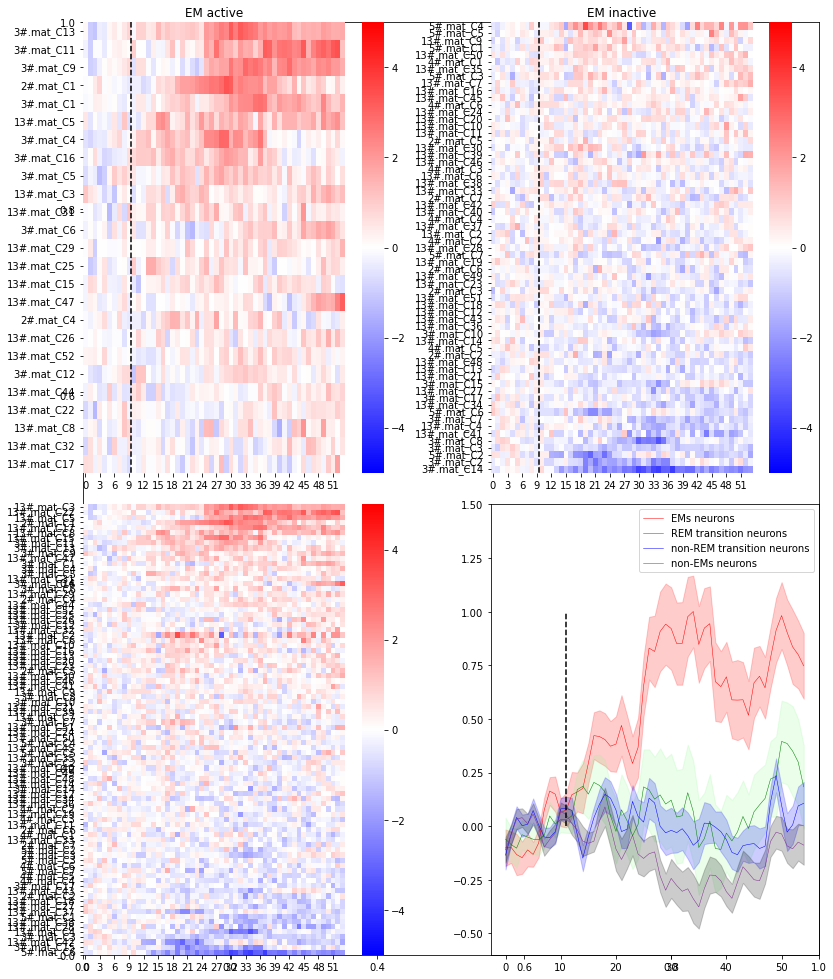

In [4]:
EM_path=r'.\rawdata\out_put\Ca_acrossStage'
arr_EM=pd.read_csv(EM_path+'\\R-matrix.csv',index_col='cell_name')
arr_val_EM=np.array(arr_EM)[np.isin(arr_EM.index,EM_active)]
arr_val_EM_name=np.array(arr_EM.index)[np.isin(arr_EM.index,EM_active)]

arr_REM=np.array(arr_EM)[np.isin(arr_EM.index,REM_active)]
arr_REM_name=np.array(arr_EM.index)[np.isin(arr_EM.index,REM_active)]

arr_nonREM=np.array(arr_EM)[np.isin(arr_EM.index,non_REM_cell)]
arr_nonREM_name=np.array(arr_EM.index)[np.isin(arr_EM.index,non_REM_cell)]

arr_excluded_EM=np.array(arr_EM)[~np.isin(arr_EM.index,EM_active)]
arr_excluded_EM_name=np.array(arr_EM.index)[~np.isin(arr_EM.index,EM_active)]

f, ax = plt.subplots(figsize=(12, 14), nrows=1)
ax1=f.add_subplot(221)
length=arr_val_EM.shape[1]
sort_val_EM1,sort_name1=sort_arr2(arr_val_EM,arr_val_EM_name,length//5,length)
sns.heatmap(sort_val_EM1, yticklabels =sort_name1, ax=ax1, vmax=5, vmin=-5, cmap='bwr')  ##
ax1.vlines(arr_val_EM.shape[1]//5,0,arr_val_EM.shape[0],colors='black',linestyles='--');plt.title('EM active')


ax2=f.add_subplot(222)

sort_val_EM2,sort_name2=sort_arr2(arr_excluded_EM,arr_excluded_EM_name,length//5,length)
sns.heatmap(sort_val_EM2, yticklabels =sort_name2, ax=ax2, vmax=5, vmin=-5, cmap='bwr')  ##
plt.vlines(arr_excluded_EM.shape[1]//5,0,arr_excluded_EM.shape[0],colors='black',linestyles='--');plt.title('EM inactive')

ax3=f.add_subplot(223)
arr=np.concatenate((sort_val_EM1,sort_val_EM2),axis=0)
arr_name=np.concatenate((arr_val_EM_name,arr_excluded_EM_name))
sns.heatmap(arr, yticklabels =arr_name, ax=ax3, vmax=5, vmin=-5, cmap='bwr')  ##
# plt.vlines(arr_excluded_EM.shape[1]//5,0,len(arr_val_EM),colors='black',linestyles='--')

ax4=f.add_subplot(224)
smooth_arr=np.array([smooth(i, 2) for i in arr_val_EM])

Ave_val_EM=np.mean(smooth_arr,axis=0)
print(len(smooth_arr))
Sem_val_EM=np.array(smooth_arr.std(axis=0, ddof=1)) / (math.sqrt(len(smooth_arr)))
ax4.plot(Ave_val_EM,linewidth=0.5,color='r',label='EMs neurons')
ax4.fill_between(range(len(Ave_val_EM)),Ave_val_EM-Sem_val_EM,Ave_val_EM+Sem_val_EM,color='r', alpha=0.2)

smooth_arr_REM=np.array([smooth(i, 2) for i in arr_REM])
Ave_REM=np.mean(smooth_arr_REM,axis=0)
Sem_REM=np.array(smooth_arr_REM.std(axis=0, ddof=1)) / (math.sqrt(len(smooth_arr_REM)))
ax4.plot(Ave_REM,linewidth=0.5,color='g',label='REM transition neurons')
ax4.fill_between(range(len(Ave_REM)),Ave_REM-Sem_REM,Ave_REM+Sem_REM,color='palegreen', alpha=0.2)

smooth_arr_nonREM=np.array([smooth(i, 2) for i in arr_nonREM])
Ave_exclu_REM=np.mean(smooth_arr_nonREM,axis=0)
Sem_exclu_REM=np.array(smooth_arr_nonREM.std(axis=0, ddof=1)) / (math.sqrt(len(smooth_arr_nonREM)))
ax4.plot(Ave_exclu_REM,linewidth=0.5,color='b',label='non-REM transition neurons')
ax4.fill_between(range(len(Ave_exclu_REM)),Ave_exclu_REM-Sem_exclu_REM,Ave_exclu_REM+Sem_exclu_REM,color='b', alpha=0.2)

smooth_arr_excluded=np.array([smooth(i, 2) for i in arr_excluded_EM])
Ave_exclu_EM=np.mean(smooth_arr_excluded,axis=0)
Sem_exclu_EM=np.array(smooth_arr_excluded.std(axis=0, ddof=1)) / (math.sqrt(len(smooth_arr_excluded)))
ax4.plot(Ave_exclu_EM,linewidth=0.5,color='#7e318e',label='non-EMs neurons')
ax4.fill_between(range(len(Ave_exclu_EM)),Ave_exclu_EM-Sem_exclu_EM,Ave_exclu_EM+Sem_exclu_EM,color='black', alpha=0.2)
ax4.vlines(len(Ave_val_EM)//5,0,1,colors='black',linestyles='--')
ax4.set_ylim(-0.6,1.5)
plt.legend()
plt.tight_layout()

np.save(path_root+'\\EM_active neurons_duringEM.npy', smooth_arr)
np.save(path_root+'\\REM_active neurons_duringEM.npy', smooth_arr_REM)
np.save(path_root+'\\EM_inactive neurons_duringEM.npy', smooth_arr_excluded)
np.save(path_root+'\\REM_inactive neurons_duringEM.npy', smooth_arr_nonREM)
# plt.savefig(path_root+'\\EM_active neurons.pdf')
# plt.savefig(path_root+'\\EM_active neurons.jpg')
plt.show()

In [5]:
if __name__ == '__main__':
    path=r'.\rawdata\network_analysis'
    new_path=path_root
    file_list=[i for i in os.listdir(path) if i.startswith('Ca')]
    cell_info=pd.read_excel(path+'\\sleep_define.xlsx',index_col=0)
    all_cell={'cell_name':[],'cell':[],'mean_before':[],'mean_after':[],'mean':[],'sleep_id':[],'em_index':[]}
    is_save='no'
    print(file_list)
    print(cell_info.sleep_ID[cell_info.index])
    max_epoch=15
    trans_number=[]

    for file in file_list:
        prefix=file[2:]
        ##睡眠状态
        stage=pd.read_csv(path+f'\\Stage{prefix}',sep=',').Stage
        Ca_data=pd.read_csv(path+f'\\{file}',sep=',')

        episodes= {'0':[],'5':[],'10':[]}
        wake_index=[x[0] for x in enumerate(stage) if x[1]==0]
        nrem_index=[x[0] for x in enumerate(stage) if x[1]==5]
        rem_index=[x[0] for x in enumerate(stage) if x[1]==10]

        # print(f"W_index:{wake_index}")
        for k, g in groupby(enumerate(wake_index),lambda x:x[0]-x[1]):
            group=list(map(itemgetter(1), g))
            episodes['0'].append((group[0], group[-1]+1))
        for k, g in groupby(enumerate(nrem_index),lambda x:x[0]-x[1]):
            group=list(map(itemgetter(1), g))
            episodes['5'].append((group[0], group[-1]+1))
        for k, g in groupby(enumerate(rem_index),lambda x:x[0]-x[1]):
            group=list(map(itemgetter(1), g))
            episodes['10'].append((group[0], group[-1]+1))

        ###计算状态转变的次数
        for start, end in episodes['10'][:-1]:    ###不同转变状态需修改
            if stage[end]!=10:
                trans_number.append(end-start)

        em_fre=pd.read_csv(path+f'\\em_fre{prefix}',sep=',').em_fre.values
        em_fre=np.array(em_fre)

        em_index=pd.read_csv(path+f'\\em_index{prefix}',sep=',').em_index.values
        em_index_list=np.array(em_index).reshape((-1,512))

        em_index_episode_mice=[]
        for i in Ca_data.columns:
            # plt.figure(figsize=(12,3),dpi=720)
            # plt.plot(Ca_data[i],lw=0.5,c='black')
            # plt.show()
            # print(i,j)
            Ca_cell=smooth(np.array(Ca_data[i]),11)
            mean_cell,std_cell=np.mean(Ca_cell),np.std(Ca_cell)
            thre_pos,thre_neg=mean_cell+1.96*std_cell,mean_cell-1.96*std_cell
            Ca_celli=Ca_cell.reshape((-1,64))

            cell_i=[]
            em_index_episode=[]

            valid_episode=0
            ###0:indicate 'W', 5: indicate 'NR', 10: indicate 'R'
            for start, end in episodes['10'][:-1]:    ###不同转变状态需修改
                idx =[idx_i for idx_i in np.arange(start, end)]
                epoch_n=[]
                ###转变前
                for num in idx:
                    if em_fre[num]!=0: ## and (len(np.where(Ca_cell[num]>thre_pos)[0])>0 or len(np.where(Ca_cell[num]<thre_neg)[0])>0)
                        epoch_n.append(1)
                    else:
                        epoch_n.append(0)

                if sum(epoch_n)==0 and 2<=len(idx)<=max_epoch and stage[end]!=10:    ###不同转变状态需修改sum(epoch_n)<len(idx)*0.5 and 2<=len(idx)<=max_epoch..
                    valid_episode+=1
                    normalized_time_len=max_epoch*2*512
                    ###nomarlize time in em index
                    em_index_episode_i =em_index_list[start:end+len(idx)].flatten()
                    # _,ins_em=ins_smooth(range(len(em_index_episode_i)),em_index_episode_i,normalized_time_len)
                    ins_em=normalized_time(em_index_episode_i,normalized_time_len)

                    em_index_episode.append(ins_em)
                    ###nomarlize time in cell activity across transition
                    stage_data = Ca_celli[start:end+len(idx)].flatten()
                    _,ins_ca=ins_smooth(range(len(stage_data)),stage_data,normalized_time_len)
                    cell_i.append(ins_ca)
            # print(valid_episode)
            if valid_episode!=0:
                em_index_episode_mice=em_index_episode

                cell_mean=np.mean(cell_i,axis=0)

                all_cell['cell'].append(cell_mean)
                all_cell['cell_name'].append(i)
                all_cell['mean_before'].append(np.mean(cell_mean[:len(cell_mean)//2]))
                all_cell['mean_after'].append(np.mean(cell_mean[len(cell_mean)//2:]))
                all_cell['mean'].append(np.mean(cell_mean))
                # all_cell['em_related_epoch'].append(trans_n)
                all_cell['sleep_id'].append(cell_info.sleep_ID[i])

                # wanted_cell=[all_cell['cell_name'][i] for i,j in enumerate(all_cell['sleep_id']) if 'NR' and 'No_response' not in str(j)] ##if 'NR' and 'No_response' not in str(j)
                # W_R_cell=all_cell['cell_name']
                # if str(i) in wanted_cell:
                    # plt.savefig(out_path+f'\\{i}_{cell_info.sleep_ID[i]}.pdf')
            else:
                continue

        if len(em_index_episode_mice)!=0:
            all_cell['em_index'].extend(em_index_episode_mice)

        #     break
        # break

['Ca_13#.txt', 'Ca_2#.txt', 'Ca_3#.txt', 'Ca_4#.txt', 'Ca_5#.txt']
cell_name
13#.mat_C52           R_NR
13#.mat_C51    No_response
13#.mat_C50            W_R
13#.mat_C49              R
13#.mat_C48            W_R
                  ...     
5#.mat_C3              W_R
5#.mat_C4                R
5#.mat_C5              W_R
5#.mat_C6      No_response
5#.mat_C7      No_response
Name: sleep_ID, Length: 88, dtype: object


C:\Users\nVoke\AppData\Local\Temp\ipykernel_14372\3039484328.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(121)


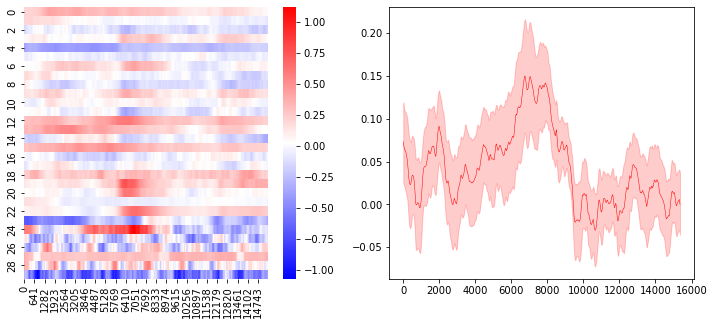

In [8]:
    df=pd.read_excel(path+'\\sleep_define.xlsx',index_col=None)
    cell_list=[df['cell_name'][i] for i,j in enumerate(df.sleep_ID) if 'R' in str(j) and 'NR' not in str(j)]
    # cell_list=df.cell_name[df.rem_positive==1]
    arr_val_REM=np.array(all_cell['cell'])[np.isin(np.array(all_cell['cell_name']),cell_list)]

    plt.subplots(figsize=(12, 5))
    plt.subplot(121)
    sns.heatmap(np.array(arr_val_REM),cmap='bwr')

    plt.subplot(122)
    Ave_val_REM=np.mean(arr_val_REM,axis=0)
    Sem_val_REM=np.array(arr_val_REM.std(axis=0, ddof=1)) / (math.sqrt(len(arr_val_REM)))
    plt.plot(Ave_val_REM,linewidth=0.5,color='r',label='REM active')
    plt.fill_between(range(len(Ave_val_REM)),Ave_val_REM-Sem_val_REM,Ave_val_REM+Sem_val_REM,color='r', alpha=0.2)

    plt.show()
    np.save(path_root+'\\arr_REM_neuronName.npy',np.array(all_cell['cell_name']))

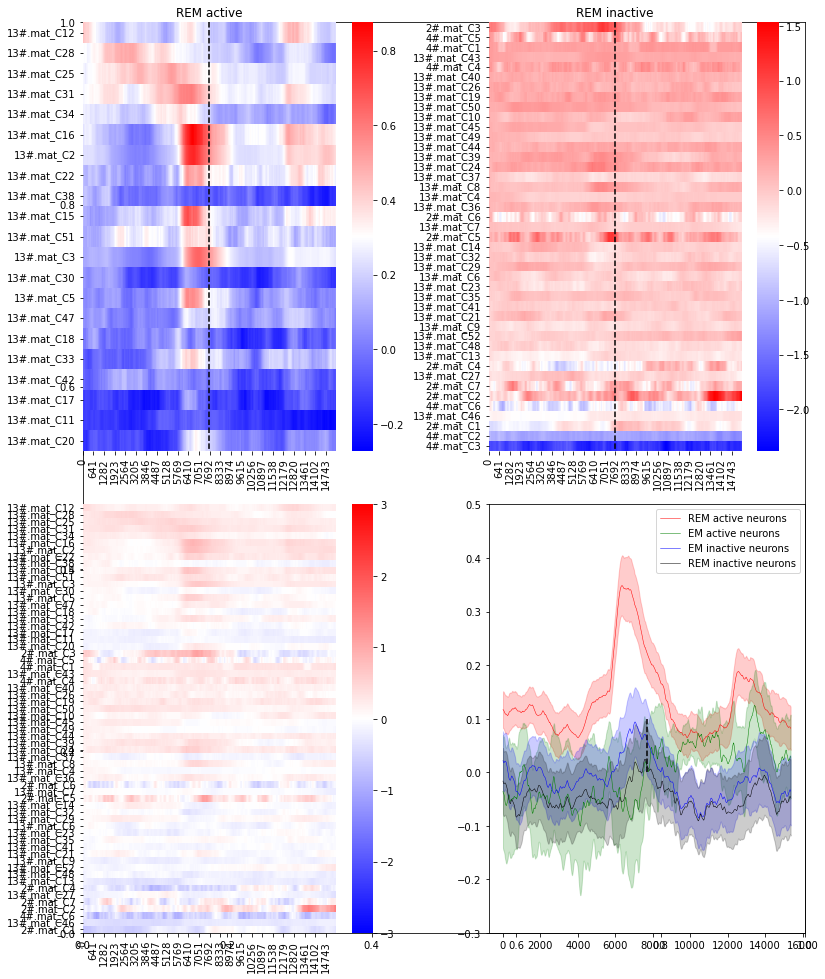

In [6]:
    arr_REM=np.array(all_cell['cell'])[np.isin(np.array(all_cell['cell_name']),REM_active)]
    arr_val_REM=np.array(all_cell['cell'])[np.isin(np.array(all_cell['cell_name']),REM_active)]
    arr_val_REM_name=np.array(all_cell['cell_name'])[np.isin(np.array(all_cell['cell_name']),REM_active)]
    ##EM active neurons
    arr_EM=np.array(all_cell['cell'])[np.isin(np.array(all_cell['cell_name']),EM_specific)]
    arr_EM_name=np.array(all_cell['cell_name'])[np.isin(np.array(all_cell['cell_name']),EM_specific)]
    ##EM inactive neurons
    arr_nonEM=np.array(all_cell['cell'])[np.isin(np.array(all_cell['cell_name']),EM_inactive)]
    arr_nonEM_name=np.array(all_cell['cell_name'])[np.isin(np.array(all_cell['cell_name']),EM_inactive)]

    arr_excluded_REM=np.array(all_cell['cell'])[~np.isin(np.array(all_cell['cell_name']),REM_active)]
    arr_excluded_REM_name=np.array(all_cell['cell_name'])[~np.isin(np.array(all_cell['cell_name']),REM_active)]

    f, ax = plt.subplots(figsize=(12, 14))
    ax1=f.add_subplot(221)
    sort_REM1,sort_REM_name1=sort_arr2(arr_val_REM,arr_val_REM_name,0,len(arr_val_REM_name)//2)
    sns.heatmap(sort_REM1, yticklabels =sort_REM_name1, ax=ax1, cmap='bwr')  ##
    ax1.vlines(arr_val_REM.shape[1]//2,0,arr_val_REM.shape[0],colors='black',linestyles='--');plt.title('REM active')

    ax2=f.add_subplot(222)
    sort_REM2,sort_REM_name2=sort_arr2(arr_excluded_REM,arr_excluded_REM_name,0,len(arr_excluded_REM_name)//2)
    sns.heatmap(sort_REM2, yticklabels = sort_REM_name2, ax=ax2, cmap='bwr')  ##
    plt.vlines(arr_excluded_REM.shape[1]//2,0,arr_excluded_REM.shape[0],colors='black',linestyles='--');plt.title('REM inactive')

    ax3=f.add_subplot(223)
    all_neurons=np.concatenate((sort_REM1,sort_REM2),axis=0)
    all_neurons_name=np.concatenate((sort_REM_name1,sort_REM_name2))
    sns.heatmap(all_neurons[:-2], yticklabels =all_neurons_name[:-2], ax=ax3, vmax=3, vmin=-3, cmap='bwr')  ##
    # plt.vlines(sort_REM1.shape[1]//2,0,len(sort_REM1),colors='black',linestyles='--')


    ax4=f.add_subplot(224)
    Ave_val_REM=np.mean(arr_val_REM,axis=0)
    Sem_val_REM=np.array(arr_val_REM.std(axis=0, ddof=1)) / (math.sqrt(len(arr_val_REM)))
    ax4.plot(Ave_val_REM,linewidth=0.5,color='r',label='REM active neurons')
    ax4.fill_between(range(len(Ave_val_REM)),Ave_val_REM-Sem_val_REM,Ave_val_REM+Sem_val_REM,color='r', alpha=0.2)

    Ave_val_EM=np.mean(arr_EM,axis=0)
    Sem_val_EM=np.array(arr_EM.std(axis=0, ddof=1)) / (math.sqrt(len(arr_EM)))
    ax4.plot(Ave_val_EM,linewidth=0.5,color='g',label='EM active neurons')
    ax4.fill_between(range(len(Ave_val_EM)),Ave_val_EM-Sem_val_EM,Ave_val_EM+Sem_val_EM,color='g', alpha=0.2)

    Ave_val_nonEM=np.mean(arr_nonEM,axis=0)
    Sem_val_nonEM=np.array(arr_nonEM.std(axis=0, ddof=1)) / (math.sqrt(len(arr_nonEM)))
    ax4.plot(Ave_val_nonEM,linewidth=0.5,color='b',label='EM inactive neurons')
    ax4.fill_between(range(len(Ave_val_nonEM)),Ave_val_nonEM-Sem_val_nonEM,Ave_val_nonEM+Sem_val_nonEM,color='b', alpha=0.2)

    Ave_exclu_REM=np.mean(arr_excluded_REM,axis=0)
    Sem_exclu_REM=np.array(arr_excluded_REM.std(axis=0, ddof=1)) / (math.sqrt(len(arr_excluded_REM)))
    ax4.plot(Ave_exclu_REM,linewidth=0.5,color='black', label='REM inactive neurons')
    ax4.fill_between(range(len(Ave_exclu_REM)),Ave_exclu_REM-Sem_exclu_REM,Ave_exclu_REM+Sem_exclu_REM,color='black', alpha=0.2)
    ax4.vlines(len(Ave_exclu_REM)//2,0,0.1,colors='black',linestyles='--')
    ax4.set_ylim(-0.3,0.5)
    plt.legend()
    plt.tight_layout()

    np.save(path_root+'\\EM_active neurons_duringTransition.npy', arr_EM)
    np.save(path_root+'\\REM_active neurons_duringTransition.npy', arr_val_REM)
    np.save(path_root+'\\EM_inactive neurons_duringTransition.npy', arr_nonEM)
    np.save(path_root+'\\REM_inactive neurons_duringTransition.npy', arr_excluded_REM)
    # plt.savefig(new_path+'\\REM_active neurons2.pdf')
    # plt.savefig(new_path+'\\REM_active neurons2.jpg')
    plt.show()


total trial: 43


C:\ProgramData\Anaconda3\envs\pythonProject1\lib\site-packages\numpy\lib\npyio.py:521: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


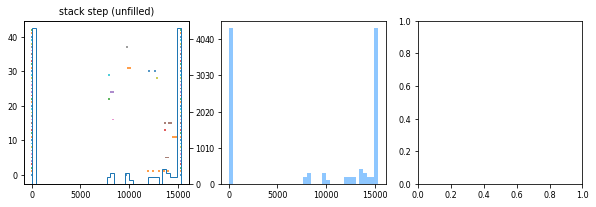

In [9]:

    ###将眼动二值化，转化为raster plot; The raster plot of the em activity
    em_index_arr=np.array(all_cell['em_index'])
    raster_tail=np.ones((em_index_arr.shape[0],1))
    em_raster_new=np.concatenate((em_index_arr,raster_tail),axis=1)
    em_raster_new=np.concatenate((raster_tail,em_raster_new),axis=1)
    print(f'total trial: {len(em_index_arr)}')
    em_raster=[]
    for i in em_raster_new:
        em_raster_i=[n[0] for n in enumerate(i) if n[1]>0.5]
        em_raster.append(em_raster_i)
    if is_save=='no':
        np.save(new_path+'\\em_raster.npy',em_raster)
    raster_plot2(em_raster,len(em_raster),new_path)  ###defualt: dataset_type=list